# Install MLC TVM Unity Package

When running the codeblock in colab, if a warning pops up telling you to restart the runtime, click the "RESTART RUNTIME" button.

In [ ]:
!pip install --pre --force-reinstall mlc-ai-nightly-cu116 mlc-chat-nightly-cu116 -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.9/426.9 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.5/346.5

# Understanding TVM Unity: The key technique in MLC-LLM

If you want to enable new model architecture in MLC-LLM, you will need to implement model on top of TVM Unity infrastructure. Here's an introduction of the core concepts of TVM Unity.


## IRModule: The key concept in TVM Unity:

To begin with, TVM unity centers around one key concept --IRModule. An IRModule is a collection of tensor functions that represents subset of computations we need to carry out in an AI model. For example, in the case of MLC-LLM it can be a transformer block.

An IRModule in a ML Compilation framework is just like tensor in deep learning frameworks. Everything will be built on top of. In the whole compilation flow, models will be imported as IRModule, then transformed an optimized in an IRModule-to-IRModule style, and then we can turn IRModule into a runnable module on any supported platform. An IRModule can be accessible in a python first way, for example, we can show it in a python AST form for inspection, tweaking and debugging. One of the main design goal of unity is to enable a single abstraction that encapsulates all main elements in the same module. This enables us to do build incremental transformations organically on top.

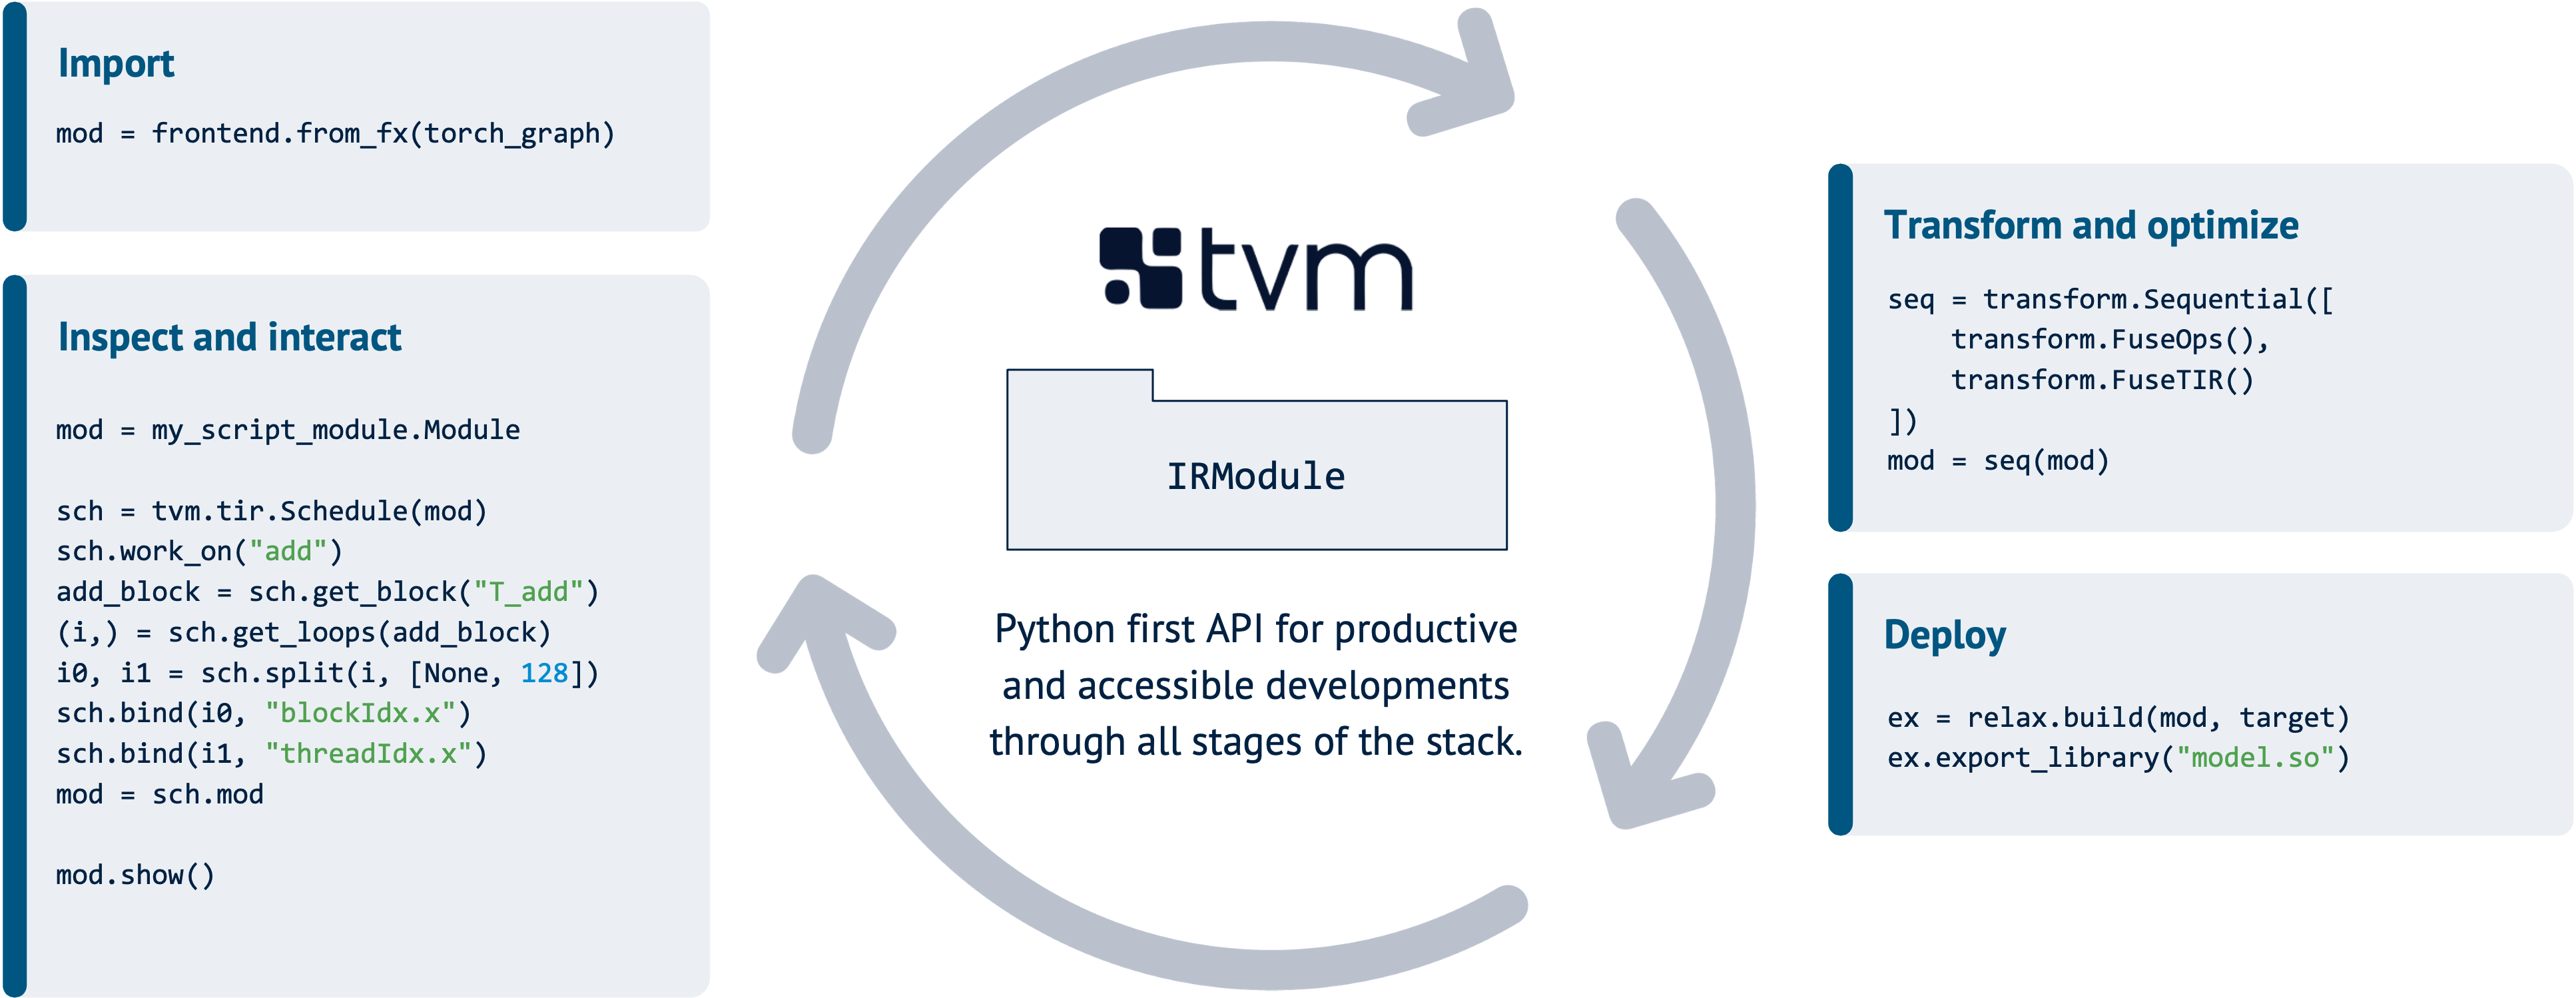

TVMScript is the python AST format of IRModule, which will serve as a centralized tool for inspecting and interacting with IRModules during the overall set of transformations. Interactions to IRModule can all happen in python, using TVMScript. Users parse TVMScript into internal IRModule structure, use python API to manipulate IRModule, and print IRModule into TVMScript format.

### TVMScript Examples

Let's start with a simple example to see how IRModule will be represented in TVMScript.

Suppose you want to implement matrix multiplication in pytorch. You can use torch.matmul or @.

In [ ]:
import torch
a = torch.randn(3, 4)
b = torch.randn(4, 5)
print(torch.matmul(a, b))

tensor([[ 1.4984, -0.1175,  1.1993, -0.3758, -3.0534],
        [ 5.1504, -1.3199,  2.0456, -2.4830, -1.6977],
        [-0.2020, -1.5930,  0.1968, -2.6766,  2.2910]])


In Relax, you can implement the equivalent matmul operator using IRModule.

In [ ]:
from tvm.script import ir as I
from tvm.script import relax as R

@I.ir_module
class Module:
    @R.function
    def main(A: R.Tensor((3, 4), dtype="float32"), B: R.Tensor((4, 5), dtype="float32")):
        with R.dataflow():
            lv: R.Tensor((3, 5), dtype="float32") = R.matmul(A, B)
            gv: R.Tensor((3, 5), dtype="float32") = lv
            R.output(gv)
        return gv

### High-level Relax operators and Dataflow Blocks

This IRModule created via the TVMScript above is a fully high-level(graph-level) abstraction, containing only one R.function(relax function). Relax function is the representation of a computation graph in IRModule.

The above example contains 2 important concepts in Relax function: high-level Relax operators and dataflow block.

The Relax function contains a high-level Relax operator R.matmul, which describe the nodes in the computation graph, and do not contain information of its low-level implementation. One high-level Relax operator may map to different low-level implementation, and TVM Unity's compilation flow will generate an implementation with good performance.

R.dataflow() is an important scope annotation of dataflow block. Specifically, within a dataflow block, all the operations need to be side-effect free. Outside a dataflow block, the operations can contain side-effect.





### A more complex TVMScript example: 2-layer MLP

Let's look at a slightly more complex model. Here is a pytorch implementation of a 2-layer MLP.
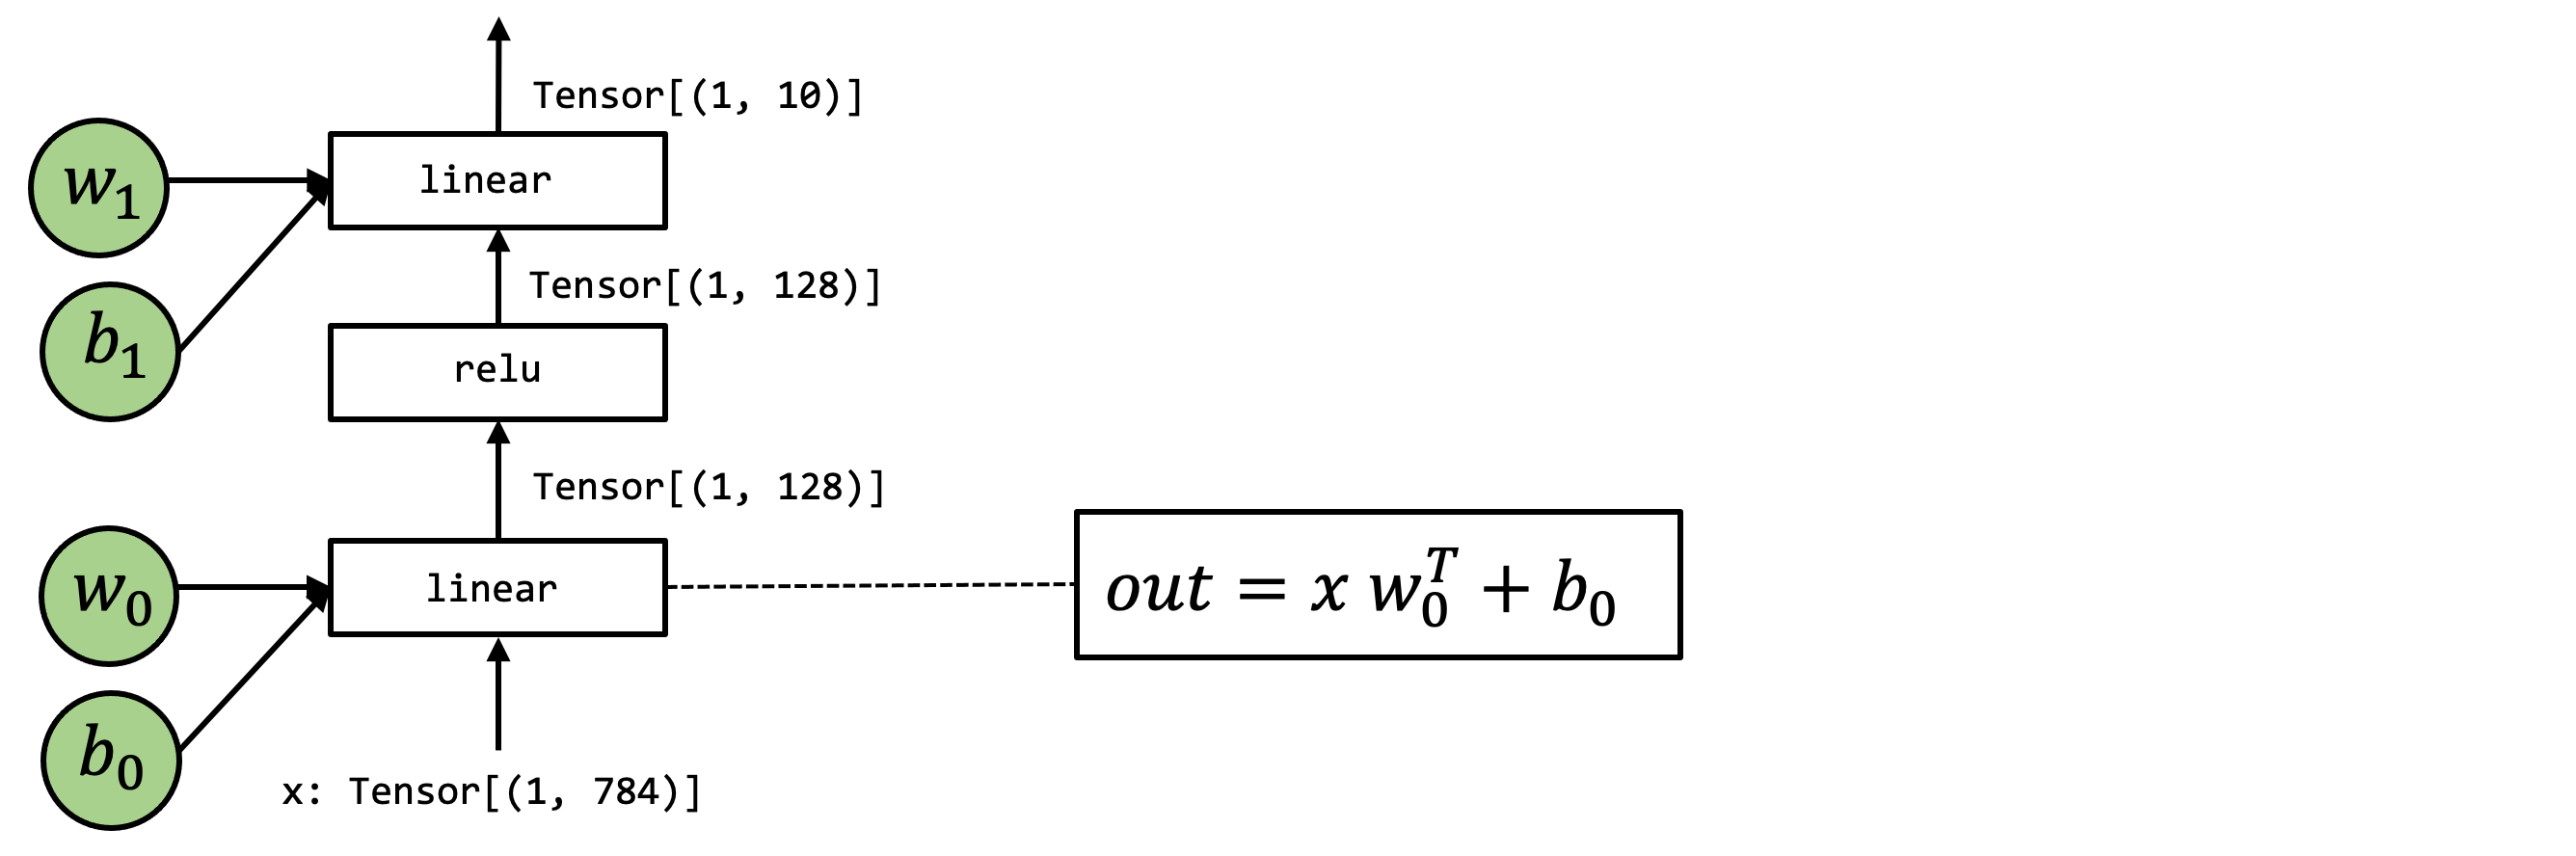

In [ ]:
import torch
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear1 = torch.nn.Linear(784, 128)
    self.linear2 = torch.nn.Linear(128, 10)

  def forward(self, x):
    x = self.linear1(x)
    x = torch.nn.functional.relu(x)
    x = self.linear2(x)
    return x


The equivalent model in IRModule is shown as TVMScript below.


In [ ]:
from tvm.script import ir as I
from tvm.script import relax as R

@I.ir_module
class Module:
    @R.function
    def main(inp_0: R.Tensor((1, 784), dtype="float32"), weight1: R.Tensor((128, 784), dtype="float32"), bias1: R.Tensor((1, 128), dtype="float32"),
             weight2: R.Tensor((10, 128), dtype="float32"), bias2: R.Tensor((1, 10), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        with R.dataflow():
            lv: R.Tensor((784, 128), dtype="float32") = R.permute_dims(weight1, axes=None)
            lv1: R.Tensor((1, 128), dtype="float32") = R.matmul(inp_0, lv, out_dtype="float32")
            lv2: R.Tensor((1, 128), dtype="float32") = R.add(lv1, bias1)
            lv3: R.Tensor((1, 128), dtype="float32") = R.nn.relu(lv2)
            lv4: R.Tensor((128, 10), dtype="float32") = R.permute_dims(weight2, axes=None)
            lv5: R.Tensor((1, 10), dtype="float32") = R.matmul(lv3, lv4, out_dtype="float32")
            lv6: R.Tensor((1, 10), dtype="float32") = R.add(lv5, bias2)
            gv: R.Tensor((1, 10), dtype="float32") = lv6
            R.output(gv)
        return gv

The Relax function above only contains high-level Relax operators (R.permute_dims, R.matmul, and R.add). To better understand these operators, we can compare them against pytorch. In pytorch, torch.nn.Linear computes $y = xA^T + b$. In relax, transposition is implemented by permute_dims, followed by matmul and add.

## Compilation flow in TVM Unity
After knowing the basic concept of IRModule, an immediate question is: How to deploy an LLM using IRModule?

The first step is importing model into IRModule. For static models, we can use pytorch dynamo to trace a pytorch program into an fx graph that can be converted to IRModule. However, LLM is usually dynamic, because the sequence length and the kv cache length are both changeable. In this case, we need to build the model directly in IRModule (We will discuss how to build model in later sections). The first step can be abstracted as LLM -> IRModule transformation.

The second step is optimizing models. Like traditional compilers, we can apply passes on IRModule. Passes are IRModule-to-IRModule transformations that changes the computation but preserves the semantics of the original IRModule. During this step, our goal is to accelerate the model computation. Most of the key techniques to running LLM on consumer devices with decent speed, like quantization, operator fusion, and tensor function scheduling, happen in this step.

The third step is deploying IRModule on devices. For every IRModule, we will be able to turn them onto a runnable module on any platform that is supported by tvm runtime. Every function on IRModule will become a native runnable function on the environment.

Here is an example of the compilation flow for the 2-layer MLP model


In [ ]:
from tvm import relax
import tvm
# Suppose we have already imported model into IRModule
# In this example, we just use the 2-layer MLP model defined before as the starting point
mod = Module

def optimize_and_deploy(mod):
  # Step 2. optimization

  # Use default graph optimization pipeline
  mod = relax.pipeline.get_pipeline()(mod)

  # Use default tensor function scheduling
  with tvm.target.Target("cuda"):
    mod = tvm.tir.transform.DefaultGPUSchedule()(mod)

  # Step 3. deploy to GPU
  ex = relax.build(mod, "cuda")
  vm = relax.VirtualMachine(ex, tvm.cuda())

  # test correctness
  import numpy as np
  input_np = np.random.rand(1, 784).astype("float32")
  weight1_np = np.random.rand(128, 784).astype("float32")
  bias1_np = np.random.rand(1, 128).astype("float32")
  weight2_np = np.random.rand(10, 128).astype("float32")
  bias2_np = np.random.rand(1, 10).astype("float32")
  tvm_nd_arrays = [tvm.nd.array(np_array, device=tvm.cuda()) for np_array in [input_np, weight1_np, bias1_np, weight2_np, bias2_np]]
  # call into the runnable function converted from IRModule
  nd_res = vm["main"](*tvm_nd_arrays)

  print("IRModule execution result:", nd_res.numpy())
  print("numpy execution result:", (input_np @ weight1_np.T + bias1_np) @ weight2_np.T + bias2_np)

optimize_and_deploy(mod)



IRModule execution result: [[12563.762 12400.238 12302.545 11653.203 12378.456 12019.794 12050.682
  12144.401 12666.688 12360.565]]
numpy execution result: [[12563.763 12400.24  12302.545 11653.206 12378.454 12019.796 12050.681
  12144.405 12666.69  12360.565]]


# nn.Module: A helper to build IRModule in Pytorch style

As we discussed before, we cannot use fx tracing to import dynamic large language model into IRModule. Instead, we need to directly build IRModules.

The most straight forward method to construct IRModule is to write TVMScript by hand. It could work for small models, but the IRModule of large language model is so large and complex that it's not practical to write by hand.

TVM Unity provides an alternative helper class, nn.Module, to construct IRModule easily just like pytorch modules.


## Use nn.Module to build IRModule via high-level Relax operators
Support you want to implement a linear layer in pytorch, the code will be like:


In [ ]:
import torch
class TorchLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
        if bias:
          self.bias = torch.nn.Parameter(torch.randn(out_features))
        else:
          self.bias = None

    def forward(self, input):
        return input @ self.weight.T + self.bias


Linear layer in Relax can be constructed by:

In [ ]:
from tvm.relax.testing import nn
from tvm import relax

class RelaxLinear(nn.Module):
    def __init__(self, in_features, out_features, dtype: str, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(
            (out_features, in_features), dtype=dtype, name="linear_weight"
        )
        if bias:
            self.bias = nn.Parameter((1, out_features), dtype=dtype, name="linear_bias")
        else:
            self.bias = None

    def forward(self, input: relax.Expr) -> relax.Var:
        return nn.emit(relax.op.linear(input, self.weight, self.bias))


It looks pretty similar with torch style, except that the forward function does not actually perform computation. It traces the operator graph using the placeholder that is passed as input.

`nn.emit(relax.op.linear(input, self.weight, self.bias))` means adding an high-level linear operator into the IRModule we are constructing.

By stacking 1 linear layers, 1 relu layer, and 1 linear layer, we can build an MLP.

In [ ]:
class RelaxMLP(nn.Module):
    def __init__(self, in_features, hidden_num, out_features, dtype="float32"):
       self.linear1 = RelaxLinear(in_features, hidden_num, dtype=dtype)
       self.linear2 = RelaxLinear(hidden_num, out_features, dtype=dtype)

    def forward(self, input: relax.Expr) -> relax.Var:
        hidden = self.linear1(input)
        hidden = nn.emit(relax.op.nn.relu(hidden))
        out = self.linear2(hidden)
        return out


Now we can define a BlockBuilder and build a linear layer in IRModule.

In [ ]:
import tvm
from tvm.ir import IRModule
def build_relax(nn_module) -> IRModule:
  # relax.BlockBuilder can construct end-to-end models step by step in an IRModule that starts empty
  bb = relax.BlockBuilder()
  # the relax nn module
  model = nn_module(784, 128, 10)
  # create a function called `linear` in the IRModule
  with bb.function("main"):
    # define input placeholder to the relax nn module
    input = nn.Placeholder((1, 784), dtype="float32", name="input")
    # build dataflow block
    with bb.dataflow():
      # call forward function of relax nn module to build IRModule
      logits = model(input)
      # The params of the constructed IRModule
      params = [input] + model.parameters()
      # return value of the dataflow block
      gv = bb.emit_output(logits)
    # return value and params of the Relax function `linear`
    bb.emit_func_output(gv, params)
  return bb.get()

print(build_relax(RelaxMLP))


# from tvm.script import ir as I
# from tvm.script import relax as R

@I.ir_module
class Module:
    @R.function
    def main(input: R.Tensor((1, 784), dtype="float32"), linear_weight: R.Tensor((128, 784), dtype="float32"), linear_bias: R.Tensor((1, 128), dtype="float32"), linear_weight_1: R.Tensor((10, 128), dtype="float32"), linear_bias_1: R.Tensor((1, 10), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        with R.dataflow():
            lv: R.Tensor((784, 128), dtype="float32") = R.permute_dims(linear_weight, axes=None)
            lv1: R.Tensor((1, 128), dtype="float32") = R.matmul(input, lv, out_dtype="void")
            lv2: R.Tensor((1, 128), dtype="float32") = R.add(lv1, linear_bias)
            lv3: R.Tensor((1, 128), dtype="float32") = R.nn.relu(lv2)
            lv4: R.Tensor((128, 10), dtype="float32") = R.permute_dims(linear_weight_1, axes=None)
            lv5: R.Tensor((1, 10), dtype="float32") = R.matmul(lv3, lv4, out_dtype="void")
            lv6: R.Tensor

Now we can go through our optimization-deployment pipeline and check if the model implementation is correct.

In [ ]:
optimize_and_deploy(build_relax(RelaxMLP))

IRModule execution result: [[11956.24   12880.094  11900.795  11539.202  11106.502  12713.3955
  13122.5625 14353.67   13045.944  13460.967 ]]
numpy execution result: [[11956.243 12880.097 11900.795 11539.2   11106.503 12713.396 13122.566
  14353.671 13045.942 13460.967]]


# How to support custom operator?

In some cases, the model we want to represent contains some custom operators that is not covered by provided Relax operators (like rotary embedding in LLaMA), or we want to do low-level optimizations to accelerate a single kernel. This sections introduces how to write custom operator in IRModule.

##  TensorIR: Low-level tensor function

TVM Unity provides a representation of low-level tensor function in IRModule, TensorIR, where users can define custom operators and perform fine-grained scheduling.

It is helpful to see the TVMScript TensorIR code and low-level torch code side-by-side and check the corresponding elements. @T.prim_func annotates that the function below is a primitive tensor functions that contains low-level details of operator implementations



In [ ]:
from tvm.script import tir as T
@T.prim_func
def matmul(rxplaceholder: T.Buffer((T.int64(1), T.int64(784)), "float32"), rxplaceholder_1: T.Buffer((T.int64(784), T.int64(128)), "float32"), matmul: T.Buffer((T.int64(1), T.int64(128)), "float32")):
    T.func_attr({"tir.noalias": True})
    # with T.block("root"):
    for i0, i1, k in T.grid(T.int64(1), T.int64(128), T.int64(784)):
        with T.block("matmul"):
            v_i0, v_i1, v_k = T.axis.remap("SSR", [i0, i1, k])
            T.reads(rxplaceholder[v_i0, v_k], rxplaceholder_1[v_k, v_i1])
            T.writes(matmul[v_i0, v_i1])
            with T.init():
                matmul[v_i0, v_i1] = T.float32(0)
            matmul[v_i0, v_i1] = matmul[v_i0, v_i1] + rxplaceholder[v_i0, v_k] * rxplaceholder_1[v_k, v_i1]

def torch_matmul(X: torch.Tensor, W: torch.Tensor):
    Y = torch.zeros(1, 128, dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                Y[i, j] = Y[i, j] + X[i, k] * W[k, j]
    return Y

note: T.prim_func is destination-passing convention, which means the input and output are explicitly allocated outside the function and passed in as arguments. Destination-passing convention enables fine-grained schedule of memory allocation, such as merging the memory allocation of two vars whose live interval don't intersect, which is the key to running large model on device with limited memory.


## Interaction between Relax function and TensorIR
To support the interaction between T.prim_func(low-level part) and R.function (high-level part), we introduce call_tir. call_tir is a special operator in Relax that describes a node in computation graph together with its tensor function implementation.

To make it easier to understand call_tir, let's take a look at pytorch equivalent of call_tir:
```
def torch_call_tir(prim_func, inputs, out_sinfo):
    res = torch.zeros(*out_sinfo.shape, dtype=out_sinfo.dtype)
    prim_func(*inputs, res)
    return res
```
Note that torch_call_tir is only a reference implementation to show the meaning of call_tir. In practice, there can be different low-level ways to optimize the execution. For example, we might choose to allocate all the output memories ahead of time and then run the execution.

Below is the IRModule of 2-layer MLP where we use `call_tir` and tensor primitive function `matmul` to replace Relax operator `R.matmul`.

In [ ]:
from tvm.script import ir as I
from tvm.script import relax as R
from tvm.script import tir as T
@I.ir_module
class Module:
    @T.prim_func
    def tir_matmul(rxplaceholder: T.Buffer((T.int64(1), T.int64(784)), "float32"), rxplaceholder_1: T.Buffer((T.int64(784), T.int64(128)), "float32"), matmul: T.Buffer((T.int64(1), T.int64(128)), "float32")):
        T.func_attr({"tir.noalias": True})
        # with T.block("root"):
        for i0, i1, k in T.grid(T.int64(1), T.int64(128), T.int64(784)):
            with T.block("matmul"):
                v_i0, v_i1, v_k = T.axis.remap("SSR", [i0, i1, k])
                T.reads(rxplaceholder[v_i0, v_k], rxplaceholder_1[v_k, v_i1])
                T.writes(matmul[v_i0, v_i1])
                with T.init():
                    matmul[v_i0, v_i1] = T.float32(0)
                matmul[v_i0, v_i1] = matmul[v_i0, v_i1] + rxplaceholder[v_i0, v_k] * rxplaceholder_1[v_k, v_i1]

    @R.function
    def main(inp_0: R.Tensor((1, 784), dtype="float32"), weight1: R.Tensor((128, 784), dtype="float32"), bias1: R.Tensor((1, 128), dtype="float32"),
             weight2: R.Tensor((10, 128), dtype="float32"), bias2: R.Tensor((1, 10), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        cls = Module
        with R.dataflow():
            lv: R.Tensor((784, 128), dtype="float32") = R.permute_dims(weight1, axes=None)
            lv1 = R.call_tir(cls.tir_matmul, [inp_0, lv], out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv2: R.Tensor((1, 128), dtype="float32") = R.add(lv1, bias1)
            lv3: R.Tensor((1, 128), dtype="float32") = R.nn.relu(lv2)
            lv4: R.Tensor((128, 10), dtype="float32") = R.permute_dims(weight2, axes=None)
            lv5: R.Tensor((1, 10), dtype="float32") = R.matmul(lv3, lv4, out_dtype="float32")
            lv6: R.Tensor((1, 10), dtype="float32") = R.add(lv5, bias2)
            gv: R.Tensor((1, 10), dtype="float32") = lv6
            R.output(gv)
        return gv

## Implement custom TensorIR function with `emit_te`

nn.Module not only support high-level Relax operators, but also support custom TensorIR function.

To build TensorIR function and call into it in Relax graph, we need to use `nn.emit_te(f_te_expr, *args)`.

`f_te_expr` is a function that returns Tensor Expression (TE), a DSL that describes tensor computation, and `args` are arguments to `f_te_expr`.

The way to create TE expression is via:
```
te.compute(out_shape, f_compute)
```

This describes the computation pattern of :

```
from itertools import product

for indices in product(range(s) for s in out_shape):
  out_tensor[*indices] = f_compute(*indices)
```

For example, if you want to write an elementwise add expression A[i, j] = B[i, j] + 1, you need to pass in the output shape, and define f_compute as `lambda i, j: B[i, j] + 1`


If you want to write a matmul expression A[i, j] = sum(B[i, k]* C[k, j]), you need to pass in the output shape, define a reduction axis k, and define f_compute as `lambda i, j: te.sum(B[i, k]* C[k, j])`.

After you define a TE expression with `f_te_expr`, `emit_te` will automatically convert TE expression to an equivalent TensorIR function.

Suppose we want to use `emit_te` to implement the matmul and transpose in linear layer. That woule be:

In [ ]:
from tvm.relax.testing import nn
from tvm import relax, te

class RelaxLinearwithEmitTE(nn.Module):
    def __init__(self, in_features, out_features, dtype: str, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(
            (out_features, in_features), dtype=dtype, name="linear_weight"
        )
        if bias:
            self.bias = nn.Parameter((1, out_features), dtype=dtype, name="linear_bias")
        else:
            self.bias = None

    def forward(self, input: relax.Expr) -> relax.Var:
        # a function that returns te expression
        def linear(input, weight):
          out_shape = input.shape[:-1]+[self.out_features,]
          k = te.reduce_axis((0, self.in_features), "k")
          return te.compute(
              out_shape,
              lambda x, y: te.sum(input[x, k] * weight[y, k], axis=k),
              name="linear",
          )
        matmul = nn.emit_te(linear, input, self.weight)
        if self.bias:
          return nn.emit(relax.op.add(matmul, self.bias))
        else:
          return matmul

class RelaxMLPwithEmitTE(nn.Module):
    def __init__(self, in_features, hidden_num, out_features, dtype="float32"):
       self.linear1 = RelaxLinearwithEmitTE(in_features, hidden_num, dtype=dtype)
       self.linear2 = RelaxLinearwithEmitTE(hidden_num, out_features, dtype=dtype)

    def forward(self, input: relax.Expr) -> relax.Var:
        hidden = self.linear1(input)
        hidden = nn.emit(relax.op.nn.relu(hidden))
        out = self.linear2(hidden)
        return out

print(build_relax(RelaxMLPwithEmitTE))


# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def linear(A: T.Buffer((T.int64(1), T.int64(784)), "float32"), B: T.Buffer((T.int64(128), T.int64(784)), "float32"), linear_1: T.Buffer((T.int64(1), T.int64(128)), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        for x, y, k in T.grid(T.int64(1), T.int64(128), T.int64(784)):
            with T.block("linear"):
                v_x, v_y, v_k = T.axis.remap("SSR", [x, y, k])
                T.reads(A[v_x, v_k], B[v_y, v_k])
                T.writes(linear_1[v_x, v_y])
                with T.init():
                    linear_1[v_x, v_y] = T.float32(0)
                linear_1[v_x, v_y] = linear_1[v_x, v_y] + A[v_x, v_k] * B[v_y, v_k]

    @T.prim_func
    def linear1(A: T.Buffer((T.int64(1), T.int64(128)), "float32"), B: T.Buffer((T.int64(10), T.int64(128)), "float32"), linear: T.Buffe

In [ ]:
optimize_and_deploy(build_relax(RelaxMLPwithEmitTE))

IRModule execution result: [[13431.437 12792.031 12954.274 12247.623 12675.775 12780.465 13119.537
  11634.037 13088.732 11973.637]]
numpy execution result: [[13431.435 12792.034 12954.276 12247.622 12675.777 12780.467 13119.537
  11634.037 13088.735 11973.635]]


## LLM Case Study: Rotary Embedding

WIP

# Related Resources

[MLC Course](https://mlc.ai/): A detailed course on machine learning compilation. Highly recommended for developers and researchers who wants to quickly try out ideas in TVM Unity.

[High-level Relax Operators List](https://github.com/mlc-ai/relax/tree/mlc/python/tvm/relax/op): Currently there's no documentation for Relax, so the best way to find the corresponding high-level Relax operator of a Pytorch operator is to check the comments in the source code of high-level Relax operators' python interface.